# 07wk-030: 아이스크림(교호작용) / 선형회귀

최규빈  
2023-10-17

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-zwhGQx-SVKqORNSrWm0TYi&si=igNDnZPiKmBIpvlx>

# 2. Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn.linear_model 
import sklearn.tree
import sklearn.model_selection

# 3. 예비학습

In [2]:
df = pd.DataFrame({'X1':[2,3,4,1],'X2':['A','B','A','C']})
df 

,X1,X2
0,2,A
1,3,B
2,4,A
3,1,C


In [3]:
pd.get_dummies(df)

,X1,X2_A,X2_B,X2_C
0,2,1,0,0
1,3,0,1,0
2,4,1,0,0
3,1,0,0,1


-   X2_A, X2_B, X2_C는 셋다 있을 필요는 없지 않나? –\> 공선성문제가
    생길수도 있음.

In [4]:
pd.get_dummies(df,drop_first=True)

,X1,X2_B,X2_C
0,2,0,0
1,3,1,0
2,4,0,0
3,1,0,1


# 4. Data

`-` load

In [7]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:100]
temp.sort()
choco = 40 + temp * 2.0 + np.random.randn(100)*3
vanilla = 60 + temp * 5.0 + np.random.randn(100)*3
df1 = pd.DataFrame({'temp':temp,'sales':choco}).assign(type='choco')
df2 = pd.DataFrame({'temp':temp,'sales':vanilla}).assign(type='vanilla')
df_train = pd.concat([df1,df2])
df_train

,temp,sales,type
0,-4.1,32.950261,choco
1,-3.7,35.852524,choco
2,-3.0,37.428335,choco
3,-1.3,38.323681,choco
4,-0.5,39.713362,choco
...,...,...,...
95,12.4,119.708075,vanilla
96,13.4,129.300464,vanilla
97,14.7,136.596568,vanilla
98,15.0,136.213140,vanilla


`-` 시각화 및 해석

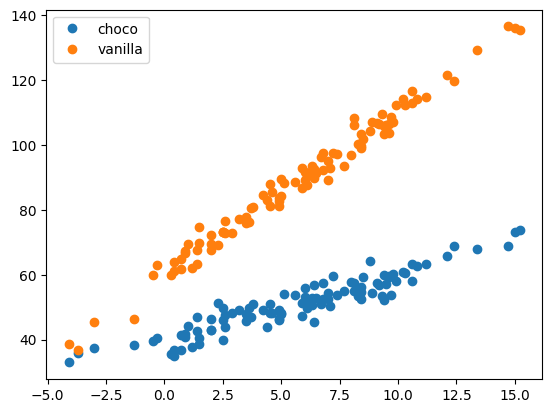

In [8]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla')
plt.legend()

-   온도에 따른 아이스크림 판매량이 아이스크림의 tpye에 따라 동일하다면
    기울기가 동일하고 절편이 다른 두 직선이 나올것임.
-   하지만 현재는 초코보다 바닐라맛이 기온의 영향을 많이 받아보임 $\to$
    (바닐라아이스크림,온도)는 (초코아이스크림,온도)보다 궁합이 좋다.
    $\to$ 아이스크림 type과 온도사이에는 교호작용이 존재한다.

# 5. 분석1

`-` 분석1: 모형을 아래와 같이 본다.

-   ${\bf X}$: `temp`, `type`
-   ${\bf y}$: `sales`

In [10]:
# step1 
X,y = pd.get_dummies(df_train[['temp','type']],drop_first=True), df_train['sales']
# step2
predictr = sklearn.linear_model.LinearRegression()
# step3
predictr.fit(X,y)
# step4 
df_train['sales_hat'] = predictr.predict(X)

In [11]:
predictr.score(X,y)

0.9249530603100549

-   점수가 잘나왔다고 너무 좋아하지 마세요.
-   시각화를 반드시 해보고 더 맞출수 있는 여지가 있는지 항상 확인할 것

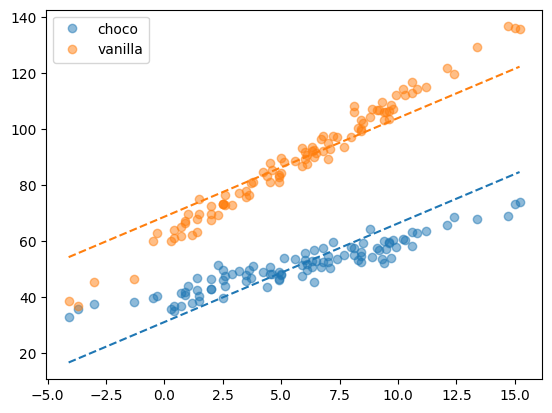

In [13]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco',color='C0',alpha=0.5)
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales_hat,'--',color='C0')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla',color='C1',alpha=0.5)
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales_hat,'--',color='C1')
plt.legend()

> 이 모형은 초코/바닐라에 대한 기울기차이를 “표현”할 수 없다. 이러한
> 상황은 “모형의 표현력이 약하다” 혹은 “언더피팅”인 상황이라고 한다.

# 6. 분석2

`-` 모형을 아래와 같이 본다.

-   ${\bf X}$: `temp`, `type`, `temp` $\times$ `type`
-   ${\bf y}$: `sales`

In [14]:
pd.get_dummies(df_train[['temp','type']],drop_first=True).eval('interaction = temp*type_vanilla')

,temp,type_vanilla,interaction
0,-4.1,0,-0.0
1,-3.7,0,-0.0
2,-3.0,0,-0.0
3,-1.3,0,-0.0
4,-0.5,0,-0.0
...,...,...,...
95,12.4,1,12.4
96,13.4,1,13.4
97,14.7,1,14.7
98,15.0,1,15.0


In [15]:
# step1 
X = pd.get_dummies(df_train[['temp','type']],drop_first=True).eval('interaction = temp*type_vanilla')
y = df_train['sales']
# step2
predictr = sklearn.linear_model.LinearRegression()
# step3
predictr.fit(X,y)
# step4 
df_train['sales_hat'] = predictr.predict(X)

In [16]:
predictr.score(X,y)

0.9865793819066231

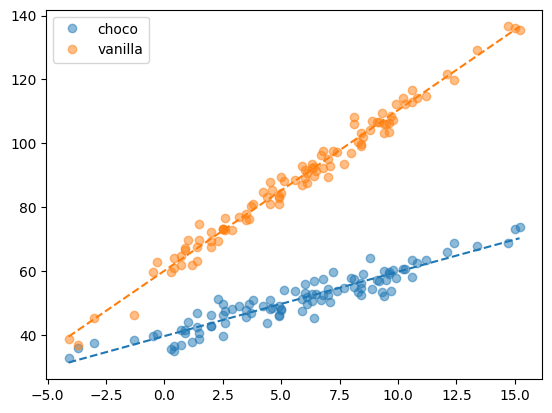

In [17]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco',color='C0',alpha=0.5)
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales_hat,'--',color='C0')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla',color='C1',alpha=0.5)
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales_hat,'--',color='C1')
plt.legend()

> Note: 초코/바닐라에 대한 절편차이는 `type`로, 초코/바닐라에 대한
> 기울기 차이는 `temp`$\times$`type`로 표현한다.